In [155]:
import gensim
from matplotlib import pyplot as plt
import nltk
import pandas as pd
import pickle
import re
from sklearn.manifold import TSNE

In [17]:
data = pd.read_hdf('census-wordlist.hdf')

In [18]:
data

,sex,age,occupation,numPeople,reg,unmodified,synonym_list,unmodified_synonym_list,additional_synonyms,additional_unmodified_synonyms
0,female,o20,Egg-merchant and Dealer,37.0,"Egg merchant,Egg dealer","Merchant,Dealer","[Egg merchant, Egg dealer]","[Merchant, Dealer]",[],"[merchant, merchandiser, trader, bargainer, de..."
1,female,u19,Egg-merchant and Dealer,3.0,"Egg merchant,Egg dealer","Merchant,Dealer","[Egg merchant, Egg dealer]","[Merchant, Dealer]",[],"[merchant, merchandiser, trader, bargainer, de..."
2,male,o20,Egg-merchant and Dealer,136.0,"Egg merchant,Egg dealer","Merchant,Dealer","[Egg merchant, Egg dealer]","[Merchant, Dealer]",[],"[merchant, merchandiser, trader, bargainer, de..."
3,male,u19,Egg-merchant and Dealer,10.0,"Egg merchant,Egg dealer","Merchant,Dealer","[Egg merchant, Egg dealer]","[Merchant, Dealer]",[],"[merchant, merchandiser, trader, bargainer, de..."
4,female,o20,Embosser,14.0,Embosser,Embosser,[Embosser],[Embosser],[],[]
5,female,u19,Embosser,4.0,Embosser,Embosser,[Embosser],[Embosser],[],[]
6,male,o20,Embosser,54.0,Embosser,Embosser,[Embosser],[Embosser],[],[]
7,male,u19,Embosser,6.0,Embosser,Embosser,[Embosser],[Embosser],[],[]
8,female,o20,Embroiderer,593.0,Embroiderer,Embroiderer,[Embroiderer],[Embroiderer],[embroiderer],[embroiderer]
9,female,u19,Embroiderer,209.0,Embroiderer,Embroiderer,[Embroiderer],[Embroiderer],[embroiderer],[embroiderer]


In [20]:
corpus = pd.read_hdf('corpus/pr-1840-1860-texts.hdf')

In [122]:
name_dict = {}
r = re.compile(r'[^a-zA-Z_]+')
for i, row in data.iterrows():
    name = row['occupation']
    name_token = name.lower().replace(' ', '_')
    name_token = r.sub('', name_token)
    if name not in name_dict:
        name_dict[name] = (name_token, set())
    name_dict[name][1].update(row['synonym_list'])

In [168]:
name_dict['Carpenter and Joiner']

('carpenter_and_joiner', {'Carpenter', 'Joiner'})

In [170]:
# Replace all instances of the synonyms with the occupation name token (so that 'carpenter' becomes
# 'carpenter_and_joiner').  Only regular plurals are handled properly.  This version takes a very long time
# to run; it could be done more efficiently with prefix trees.
alltext = []
for i, row in corpus.iterrows():
    text = row['text']
    alltext.append(text)
alltext = ''.join(alltext).lower()
for name in name_dict:
    name_token, syns = name_dict[name]
    for syn in syns:
        syn = syn.lower()
        r = re.compile('([^a-z_])' + re.escape(syn).replace(r'\ ', '[ -]') + '((e?s)?[^a-z_])')
        alltext = r.sub(r'\1' + name_token + r'\2', alltext)

In [171]:
sentences = nltk.sent_tokenize(alltext)
allsents = []
for sent in sentences:
    toks = nltk.word_tokenize(sent)
    toks = [tok.lower() for tok in toks if re.match(r'[a-zA-Z]', tok)]
    allsents.append(toks)

In [172]:
f = open('corpus/pr-1840-1860-alltexts-phrases.txt', 'w')
f.write('\n'.join([' '.join(toks) for toks in allsents]) + '\n')
f = open('corpus/pr-1840-1860-alltexts-phrases.pkl', 'wb')
pickle.dump(allsents, f)

In [278]:
model = gensim.models.Word2Vec(allsents, size=100, window=20, min_count=5, workers=4)

In [279]:
model.save("pr-1840-1860.model")

In [280]:
model.wv.most_similar('carpenter_and_joiner')

/anaconda3/lib/python3.6/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('surgeon_apothecary_and_medical_student', 0.6252232193946838),
 ('waiter', 0.6145285367965698),
 ('hawker_huckster_and_pedlar', 0.6109327673912048),
 ('chowles', 0.5976784825325012),
 ('policeofficer_constable_and_watchman', 0.5943148136138916),
 ('brazier_brassfinisher_and_worker_and_tinker', 0.5941779017448425),
 ('policeman', 0.571178138256073),
 ('grinder', 0.569864809513092),
 ('grocer_and_teadealer', 0.5636467933654785),
 ('maid-of-all-work', 0.5557292103767395)]

In [281]:
model.wv.most_similar('artist_fine_arts')

/anaconda3/lib/python3.6/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('actor_play', 0.7477108836174011),
 ('actress', 0.7318748235702515),
 ('painter_plumber_and_glazier', 0.7104263305664062),
 ('appendage', 0.6879908442497253),
 ('imitation', 0.6834045052528381),
 ('allegory', 0.6765827536582947),
 ('irishman', 0.6651742458343506),
 ('englishman', 0.6506136655807495),
 ('admirer', 0.6449175477027893),
 ('observer', 0.6442061066627502)]

In [282]:
model.wv.most_similar(['king', 'woman'], ['man'])

/anaconda3/lib/python3.6/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('queen', 0.8552473783493042),
 ('elizabeth', 0.7788899540901184),
 ('princess', 0.7690113186836243),
 ('duchess', 0.7399453520774841),
 ('royal', 0.6378989219665527),
 ('rosalba', 0.615581750869751),
 ('prince', 0.6041463017463684),
 ('boleyn', 0.5992051362991333),
 ('ida', 0.5985207557678223),
 ('countess', 0.5974318981170654)]

In [283]:
occupations_in_corpus = []
for name in name_dict:
    name_tok, _ = name_dict[name]
    try:
        model.wv[name_tok]
    except KeyError:
        continue
    occupations_in_corpus.append(name)
len(occupations_in_corpus)

147

In [284]:
occ_vecs = []
occ_names = []
for name in occupations_in_corpus:
    name_tok, _ = name_dict[name]
    sing_vec = model.wv[name_tok]
    #try:
    #    plur_vec = model.wv[name_tok + 's']
    #except KeyError:
    #    try:
    #        plur_vec = model.wv[name_tok + 'es']
    #    except KeyError:
    #        plur_vec = None
    #if plur_vec is not None:
    #    occ_vecs.append((sing_vec + plur_vec) / 2)
    #else:
    #    occ_vecs.append(sing_vec)
    occ_vecs.append(sing_vec)
    occ_names.append(name)
df = pd.DataFrame(occ_vecs, index=occ_names)

In [285]:
tsne_model = TSNE(n_components=2, random_state=0)
tsne = tsne_model.fit_transform(df)

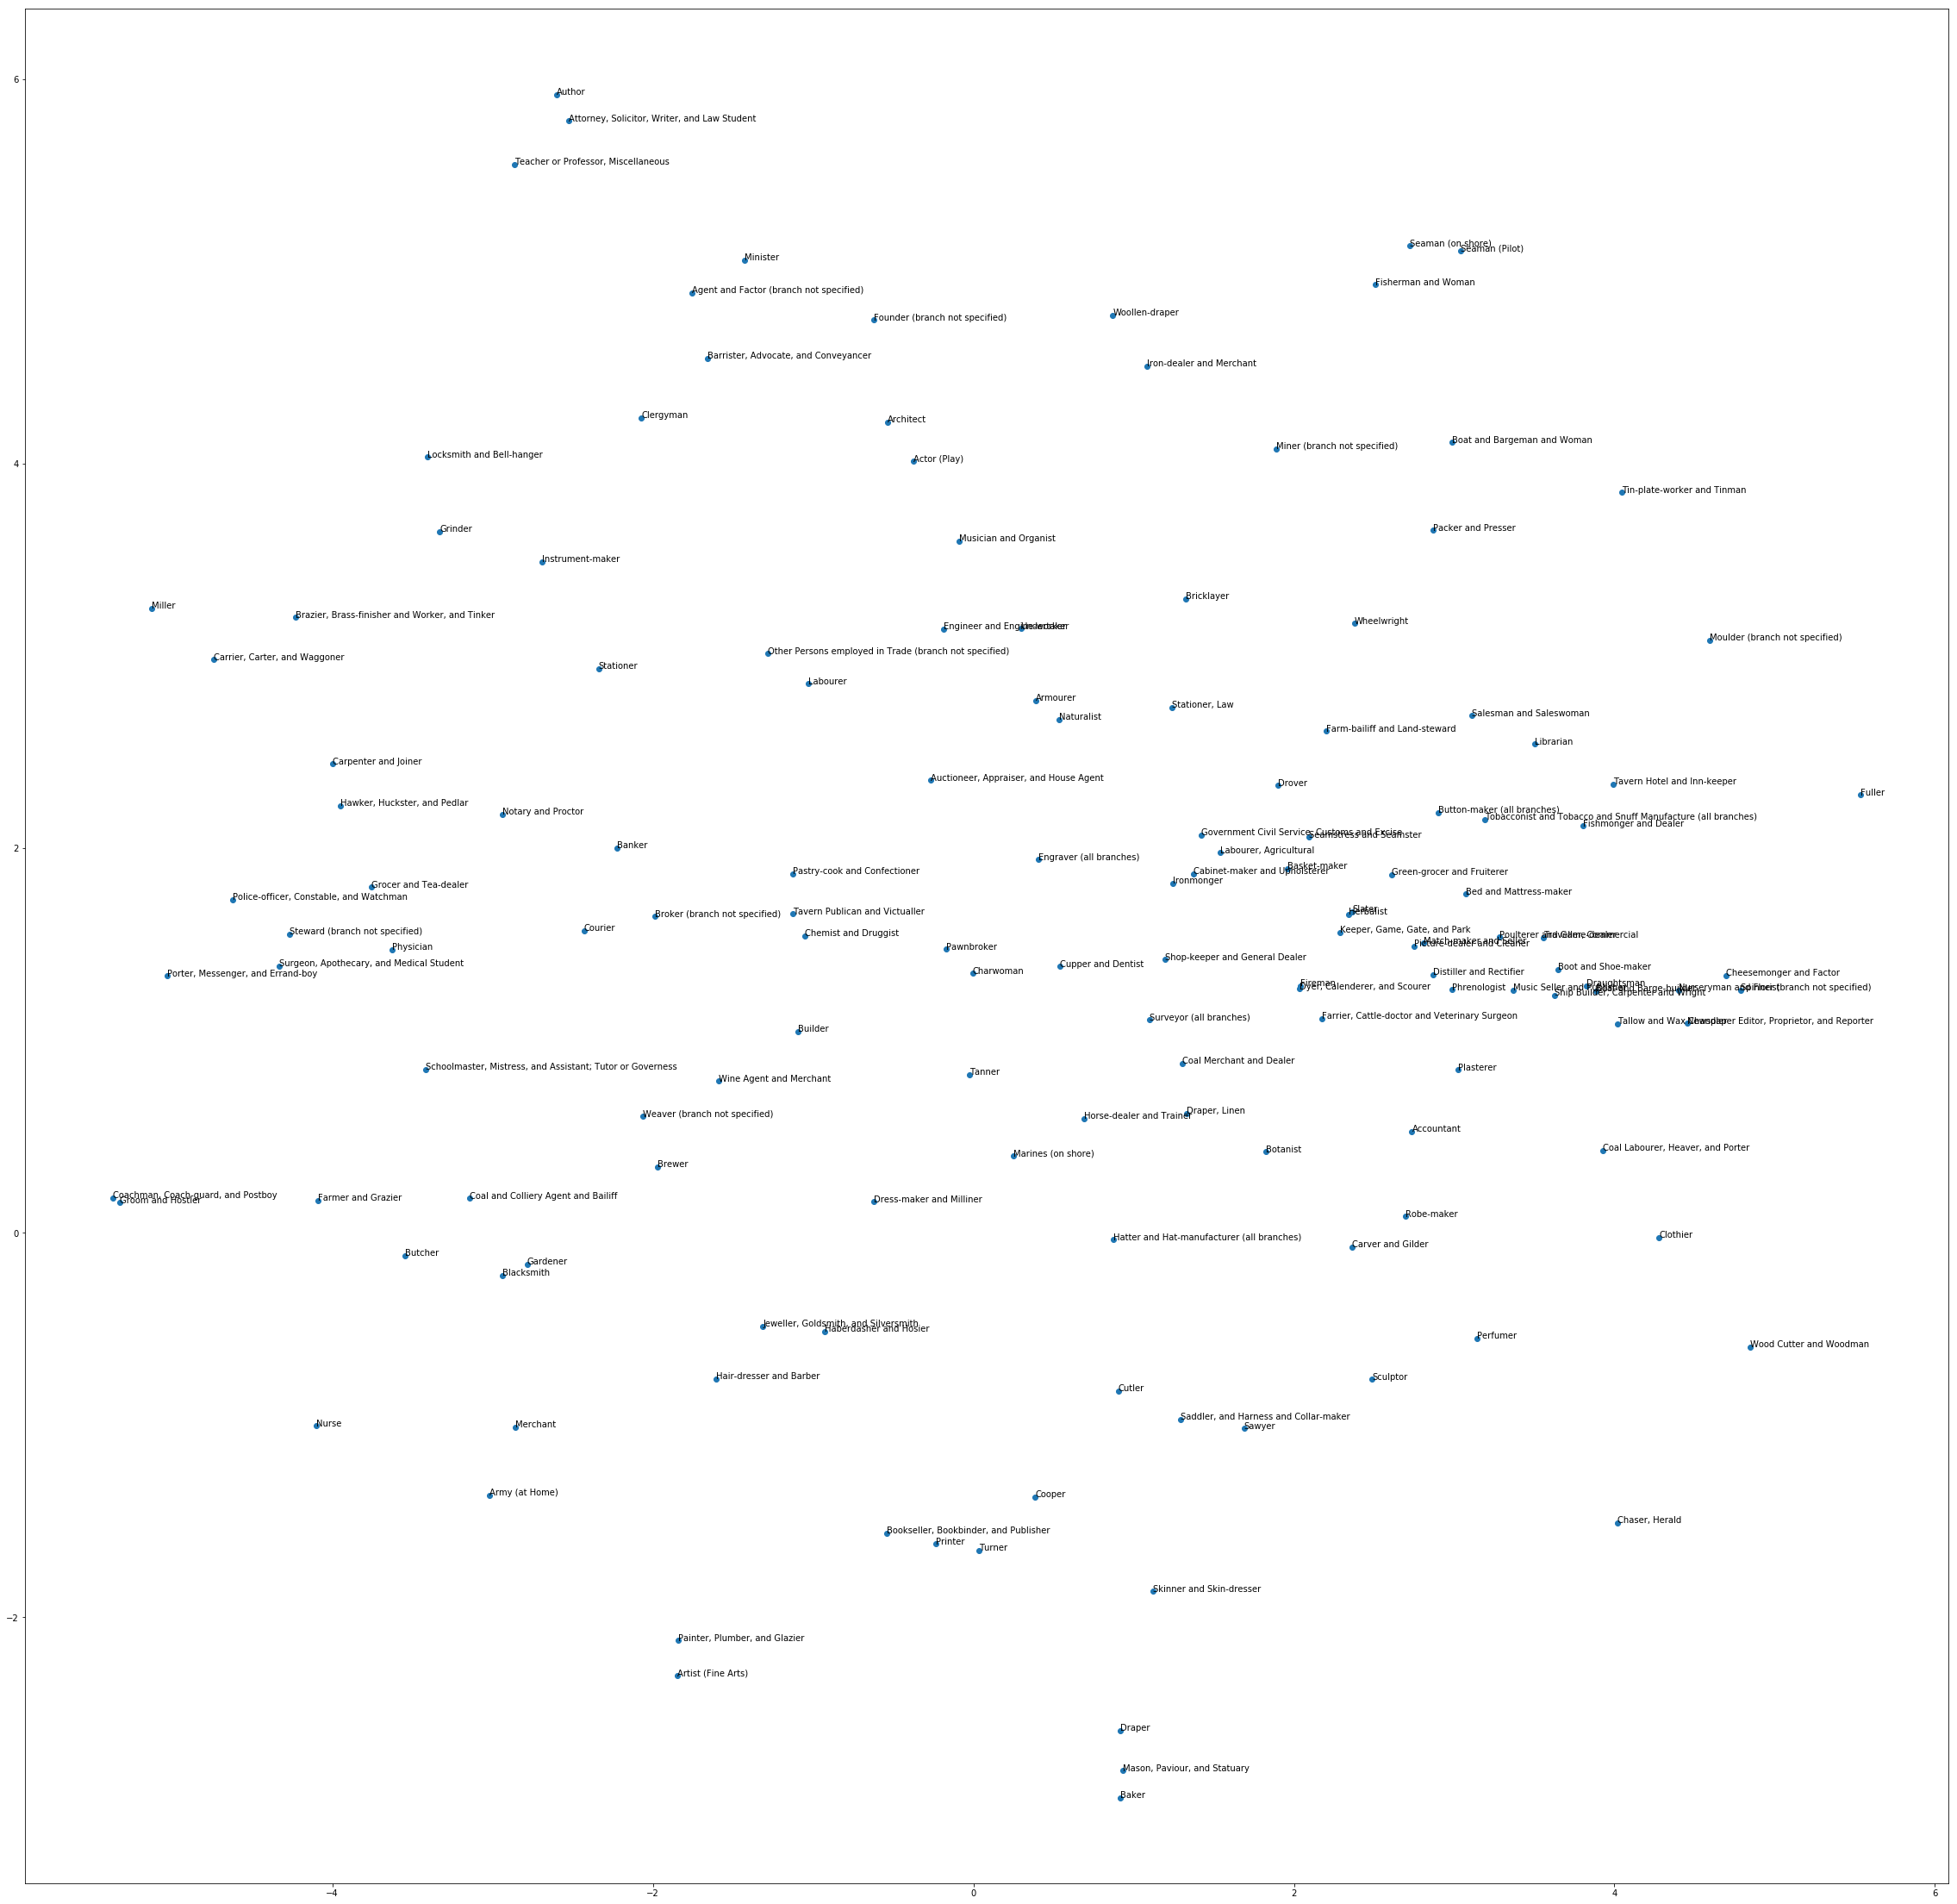

In [286]:
plt.rcParams["figure.figsize"] = (40,40)
plt.scatter(tsne[:,0], tsne[:,1])
for label, x, y in zip(occ_names, tsne[:, 0], tsne[:, 1]):
    plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')